# Import the required libraries

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Load Dataset

In [5]:
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('Electronics.csv',names=columns)

In [6]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,A1N070NS9CJQ2I,60009810,5,1026864000
1,A3P0KRKOBQK1KN,60009810,5,1025913600
2,A192HO2ICJ75VU,60009810,5,1025654400
3,A2T278FKFL3BLT,60009810,4,1025395200
4,A2ZUXVTW8RXBXW,60009810,5,1025222400


Dropping the timestamp column

In [8]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [9]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1048576 non-null  object
 1   productId  1048576 non-null  object
 2   ratings    1048576 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


In [10]:
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  1048576
Number of columns:  3


In [11]:
electronics_df.dtypes

userId       object
productId    object
ratings       int64
dtype: object

In [12]:
electronics_df1=electronics_df.iloc[:100000,0:]

In [13]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     100000 non-null  object
 1   productId  100000 non-null  object
 2   ratings    100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [14]:
electronics_df1['ratings'].describe().transpose()

count    100000.000000
mean          4.172710
std           1.297959
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

In [15]:
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [16]:
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


#### Distribution of Rating

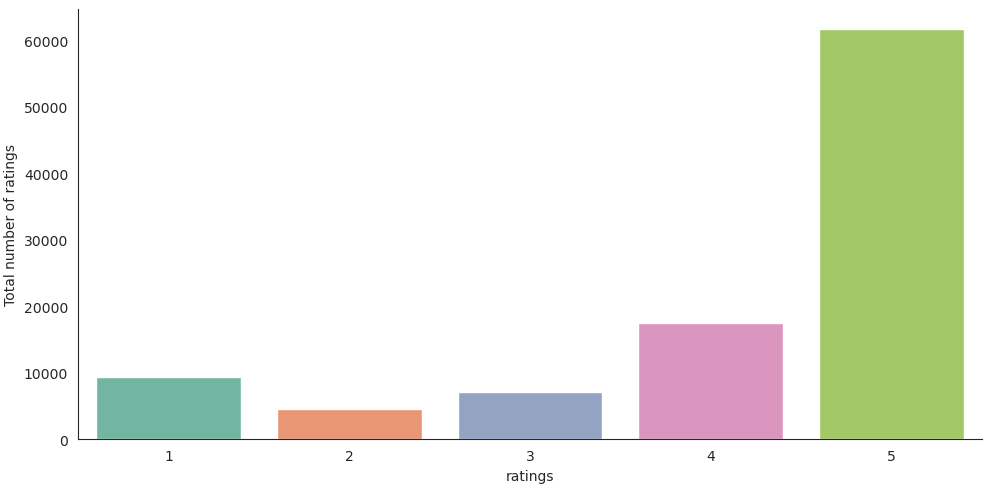

In [18]:
with sns.axes_style('white'):
    g = sns.catplot(
        x="ratings", 
        data=electronics_df1, 
        aspect=2.0, 
        kind='count', 
        palette="Set2"
    )
    g.set_ylabels("Total number of ratings")


#### Users and Products

In [20]:
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  95191
Number of unique product in Raw data =  1290


## Taking a Subset of dataset to make it less sparse/denser 

In [22]:
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    36
A2BGZ52M908MJY    18
A1RPTVW5VEOSI     17
A1NVD0TKNS1GT5    16
A3MEIR72XKQY88    14
AY8Q1X7G96HV5     13
A2G2QNKDL1Y6AC    12
A23ZO1BVFFLGHO    12
A3IBOQ8R44YG9L    11
A25E8V5JMW43RY    11
dtype: int64


In [23]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 87
Number of unique users in the final data =  4
Number of unique products in the final data =  4


### Ratings Analysis in Final Dataset

In [25]:
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y2ZF,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV
userId,,,,,,,,,,,,,,,,,,,,,
A1NVD0TKNS1GT5,0.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,5.0,0.0,3.0,4.0,4.0,5.0,4.0,0.0,0.0
A2BGZ52M908MJY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0


In [26]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (4, 80)


In [27]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  87
possible_num_of_ratings =  320
density: 27.19%


# Splitting the dataset

In [29]:
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
88629,A231WM2Z2JL0U3,B00004Y2MM,5
89237,A231WM2Z2JL0U3,B00004YBVE,3
29788,A1NVD0TKNS1GT5,B00000J579,5
79170,A231WM2Z2JL0U3,B00004VUC8,4
87679,A231WM2Z2JL0U3,B00004XP73,3


In [30]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (60, 3)
Shape of testing data:  (27, 3)


## Building Popularity Recommder model

In [32]:
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,B00000J061,1
1,B00000J1U8,1
2,B00000J579,1
3,B00000JBIA,1
4,B00000JBK6,1
5,B00000K3RO,1
6,B00000K4KH,1
7,B00001QHP5,1
8,B00001RMCY,1
9,B000021YUO,1


## Sort the products on recommendation score and Generate a recommendation rank based upon score
### Get the top 5 recommendations

In [34]:
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 

train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 

popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
23,B00004SB92,2,1.0
42,B00004W3YX,2,2.0
0,B00000J061,1,3.0
1,B00000J1U8,1,4.0
2,B00000J579,1,5.0


In [35]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
    user_recommendations['userId'] = user_id 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [36]:
find_recom = [10,100,150]
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

    userId   productId  score  rank
23      10  B00004SB92      2   1.0
42      10  B00004W3YX      2   2.0
0       10  B00000J061      1   3.0
1       10  B00000J1U8      1   4.0
2       10  B00000J579      1   5.0


The list of recommendations for the userId: 100

    userId   productId  score  rank
23     100  B00004SB92      2   1.0
42     100  B00004W3YX      2   2.0
0      100  B00000J061      1   3.0
1      100  B00000J1U8      1   4.0
2      100  B00000J579      1   5.0


The list of recommendations for the userId: 150

    userId   productId  score  rank
23     150  B00004SB92      2   1.0
42     150  B00004W3YX      2   2.0
0      150  B00000J061      1   3.0
1      150  B00000J1U8      1   4.0
2      150  B00000J579      1   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# Building Collaborative Filtering recommender model

In [39]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,88629,A231WM2Z2JL0U3,B00004Y2MM,5
1,89237,A231WM2Z2JL0U3,B00004YBVE,3
2,29788,A1NVD0TKNS1GT5,B00000J579,5
3,79170,A231WM2Z2JL0U3,B00004VUC8,4
4,87679,A231WM2Z2JL0U3,B00004XP73,3


## User Based Collaborative Filtering model

In [41]:
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y2ZF,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV
userId,,,,,,,,,,,,,,,,,,,,,
A1NVD0TKNS1GT5,0.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,5.0,0.0,3.0,4.0,4.0,5.0,4.0,0.0,0.0
A2BGZ52M908MJY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0


In [42]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (4, 80)


In [43]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1NVD0TKNS1GT5,0.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1RPTVW5VEOSI,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A231WM2Z2JL0U3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,5.0,0.0,3.0,4.0,4.0,5.0,4.0,0.0,0.0,2
A2BGZ52M908MJY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,3


In [44]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y2ZF,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,5.0,0.0,3.0,4.0,4.0,5.0,4.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0


As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [47]:
print(pivot_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 80 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   B00000J061  4 non-null      float64
 1   B00000J1U8  4 non-null      float64
 2   B00000J1US  4 non-null      float64
 3   B00000J579  4 non-null      float64
 4   B00000JBIA  4 non-null      float64
 5   B00000JBJQ  4 non-null      float64
 6   B00000JBK6  4 non-null      float64
 7   B00000JSGF  4 non-null      float64
 8   B00000K3RI  4 non-null      float64
 9   B00000K3RO  4 non-null      float64
 10  B00000K4KH  4 non-null      float64
 11  B00001QHP5  4 non-null      float64
 12  B00001RMCY  4 non-null      float64
 13  B00001ZUNQ  4 non-null      float64
 14  B000021YUO  4 non-null      float64
 15  B000023VUL  4 non-null      float64
 16  B00002JXBI  4 non-null      float64
 17  B00002JXFH  4 non-null      float64
 18  B00002SWHH  4 non-null      float64
 19  B00003006E  4 non-null      float64
 2

In [48]:
k = min(pivot_df.shape[0] - 1, pivot_df.shape[1] - 1)
U, sigma, Vt = svds(csr_matrix(pivot_df.values), k=k)

In [49]:
print("U shape:", U.shape)
print("Sigma shape:", sigma.shape)
print("Vt shape:", Vt.shape)

U shape: (4, 3)
Sigma shape: (3,)
Vt shape: (3, 80)


In [50]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.18066171 -0.45125557 -0.10119098]
 [-0.27175988 -0.87119255 -0.06410388]
 [ 0.14948685  0.07484013 -0.98016185]
 [-0.93336038  0.17830004 -0.15790448]]


In [51]:
print('Sigma: \n',sigma)

Sigma: 
 [16.72210067 17.91093881 27.05030351]


In [52]:
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[16.72210067  0.          0.        ]
 [ 0.         17.91093881  0.        ]
 [ 0.          0.         27.05030351]]


In [53]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.0812577   0.05401885  0.04469739  0.05401885 -0.01625154  0.04321508
   0.04321508  0.03575791 -0.04875462 -0.06500616  0.04469739 -0.0812577
   0.05401885 -0.06500616  0.04469739  0.04469739  0.02681843  0.04321508
   0.02681843  0.04321508  0.03241131 -0.11163195  0.04469739 -0.0812577
   0.02681843  0.04469739 -0.0812577   0.04321508 -0.22326391  0.08791247
  -0.0812577   0.04469739  0.01745854  0.03575791  0.03575791  0.04469739
   0.03241131  0.03241131 -0.11163195 -0.04875462 -0.27907988  0.05401885
  -0.17856651 -0.23438249  0.04469739 -0.0812577   0.03575791  0.04469739
  -0.04875462 -0.27907988  0.04469739 -0.27907988 -0.22326391 -0.27907988
   0.03575791  0.03575791 -0.22326391 -0.06500616 -0.04875462 -0.17856651
  -0.11163195 -0.0812577  -0.0812577   0.03575791 -0.08481352 -0.11163195
   0.04469739  0.02681843  0.04321508  0.04469739  0.04321508  0.04469739
  -0.27907988  0.02681843  0.03575791  0.03575791  0.04469739  0.03575791
  -0.27907988 -

### Predicted Ratings in Dataframead()

In [55]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y2ZF,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV
0,1.752603,1.232549,0.462090,1.232549,0.350521,0.986039,0.986039,0.369672,1.051562,1.402082,...,0.986039,0.462090,-1.165514,0.277254,0.369672,0.369672,0.462090,0.369672,-1.165514,-0.932411
1,4.184696,1.752603,-0.214963,1.752603,0.836939,1.402082,1.402082,-0.171970,2.510818,3.347757,...,1.402082,-0.214963,0.542193,-0.128978,-0.171970,-0.171970,-0.214963,-0.171970,0.542193,0.433754
2,-0.214963,0.462090,4.943323,0.462090,-0.042993,0.369672,0.369672,3.954658,-0.128978,-0.171970,...,0.369672,4.943323,0.142954,2.965994,3.954658,3.954658,4.943323,3.954658,0.142954,0.114363
3,0.542193,-1.165514,0.142954,-1.165514,0.108439,-0.932411,-0.932411,0.114363,0.325316,0.433754,...,-0.932411,0.142954,4.639432,0.085773,0.114363,0.114363,0.142954,0.114363,4.639432,3.711545


Recommend the items with the highest ratings

In [57]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    user_idx = userID-1 
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [58]:
userID = 1
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                   user_ratings  user_predictions
Recommended Items                                
B00000J061                  0.0          1.752603
B00004WCIA                  0.0          1.752603
B00001QHP5                  0.0          1.752603
B00004S9WQ                  0.0          1.752603
B00004RIPE                  0.0          1.752603


In [59]:
userID = 2
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B00000J1U8                  0.0          1.752603
B00004SY4H                  0.0          1.752603
B00001RMCY                  0.0          1.752603
B00000J579                  0.0          1.752603
B00004RJYB                  0.0          1.402082


In [60]:
userID = 3
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 3):

                   user_ratings  user_predictions
Recommended Items                                
B00001RMCY                  0.0          0.462090
B00004SY4H                  0.0          0.462090
B00000J579                  0.0          0.462090
B00000J1U8                  0.0          0.462090
B00003006E                  0.0          0.369672


Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# Evaluation of Collabrative recommendation model

#### Actual Ratings

In [64]:
final_ratings_matrix.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y2ZF,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV
userId,,,,,,,,,,,,,,,,,,,,,
A1NVD0TKNS1GT5,0.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,5.0,0.0,3.0,4.0,4.0,5.0,4.0,0.0,0.0
A2BGZ52M908MJY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0


#### Average ACTUAL rating for each item

In [66]:
final_ratings_matrix.mean().head()

productId
B00000J061    1.25
B00000J1U8    1.25
B00000J1US    1.25
B00000J579    1.25
B00000JBIA    0.25
dtype: float64

#### Predicted Ratings

In [68]:
preds_df.head()

productId,B00000J061,B00000J1U8,B00000J1US,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JSGF,B00000K3RI,B00000K3RO,...,B00004Y2ZF,B00004Y7CF,B00004YAHK,B00004YBVE,B00004YBVF,B00004YKDQ,B00004YMBK,B00004YRVY,B00004YV85,B00004YZLV
0,1.752603,1.232549,0.462090,1.232549,0.350521,0.986039,0.986039,0.369672,1.051562,1.402082,...,0.986039,0.462090,-1.165514,0.277254,0.369672,0.369672,0.462090,0.369672,-1.165514,-0.932411
1,4.184696,1.752603,-0.214963,1.752603,0.836939,1.402082,1.402082,-0.171970,2.510818,3.347757,...,1.402082,-0.214963,0.542193,-0.128978,-0.171970,-0.171970,-0.214963,-0.171970,0.542193,0.433754
2,-0.214963,0.462090,4.943323,0.462090,-0.042993,0.369672,0.369672,3.954658,-0.128978,-0.171970,...,0.369672,4.943323,0.142954,2.965994,3.954658,3.954658,4.943323,3.954658,0.142954,0.114363
3,0.542193,-1.165514,0.142954,-1.165514,0.108439,-0.932411,-0.932411,0.114363,0.325316,0.433754,...,-0.932411,0.142954,4.639432,0.085773,0.114363,0.114363,0.142954,0.114363,4.639432,3.711545


#### Average PREDICTED ratings

In [70]:
preds_df.mean().head()

productId
B00000J061    1.566132
B00000J1U8    0.570432
B00000J1US    1.333351
B00000J579    0.570432
B00000JBIA    0.313226
dtype: float64

In [71]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(80, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
B00000J061,1.25,1.566132,0
B00000J1U8,1.25,0.570432,1
B00000J1US,1.25,1.333351,2
B00000J579,1.25,0.570432,3
B00000JBIA,0.25,0.313226,4


In [72]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.28381 



# Getting top - K ( K = 3) recommendations.

In [74]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00004WCBU                  0.0          0.542193
B00004WCIA                  0.0          0.542193
B00004TH2W                  0.0          0.542193
B00001QHP5                  0.0          0.542193
B00004S9WQ                  0.0          0.542193


# Summary Insights

The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 1, 2 & 3, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.